In [ ]:
import numpy as np
class SeqEmbedding():
    def __init__(self):
        self.Dictionary = {}

    def __Sequence_to_Numeric(self,k,sequence):
        if k==0:
            temp = [0] * self.size_of_vector
            temp[len(self.Dictionary)] = 1
            self.Dictionary[sequence] = temp
            return
        nucleotide = ['A','C','G','T']
        for n in nucleotide:
            self.__Sequence_to_Numeric(k-1,sequence+n)
        return

    def fit(self, sequences, window_size, stride_size):
        self.size_of_vector = 4 ** window_size
        self.__Sequence_to_Numeric(window_size,"")

        vectorized = []

        for seq in sequences:
            first_layer_embedding = []
            for k in range(window_size, len(seq)+1, stride_size):
                try:
                    first_layer_embedding.append(self.Dictionary[seq[k-window_size:k]])
                except:
                    # exception may occur because of stride size, sometimes it may not get sequence of length window size, there will be a key not found exception in Dictionary
                    first_layer_embedding.append([0]*self.size_of_vector)
            
            vector0 = []
            vector1 = []
            for i in range(len(first_layer_embedding)):
                if i>0:
                    vector1+=first_layer_embedding[i]
                vector0+=first_layer_embedding[i]
            vector1+=first_layer_embedding[0]

            vectorized.append([vector0, vector1])
        
        # Handling inequal length problem using zero padding
        max_len = 0
        for vec in vectorized:
            max_len = max(max_len, len(vec[0]))
        for i in range(len(vectorized)):
            required = max_len - len(vectorized[i][0])

            vectorized[i][0]+=([0]*required)
            vectorized[i][0] = vectorized[i][0][:31752] # to fit into 252 * 252 pixel size, removing 120 elements
            vectorized[i][0] = np.array(vectorized[i][0])

            vectorized[i][1]+=([0]*required)
            vectorized[i][1] = vectorized[i][1][:31752] # to fit into 252 * 252 pixel size, removing 120 elements
            vectorized[i][1] = np.array(vectorized[i][1])

            vectorized[i] = np.array(vectorized[i])
            
        return np.array(vectorized)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file = open("/content/drive/MyDrive/Introduction to Bioinformatics/Project Proposal/Dataset/histone/H3K4me2.txt","r")
sequences = []
class_label = []
for line in file:
    if '>' in line:
        continue
    line = line[:-1]
    if len(line)>1:
        sequences.append(line)
    else:
        class_label.append(int(line)) 
file.close()

In [ ]:
from sklearn.model_selection import train_test_split
train_sz = (5000.0/len(sequences))
sequences, _sequences, class_label, _class_label = train_test_split(sequences, class_label, train_size = train_sz, random_state=42, stratify=class_label)

In [ ]:
class_label = np.array(class_label)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, class_label, test_size=0.2, random_state=42, stratify=class_label)

In [ ]:
instance = SeqEmbedding()
X_train_val = instance.fit(sequences = X_train_val, window_size = 3, stride_size = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify = y_train_val)

In [ ]:
print(X_train.shape)

(3600, 2, 31752)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

model = SVC(kernel = 'linear')
model.fit(X_train.reshape(X_train.shape[0], -1),y_train)
y_pred = model.predict(X_val.reshape(X_val.shape[0], -1))
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')

Accuracy Score: 0.5791666666666667


In [ ]:
X_train = X_train.reshape(X_train.shape[0],252, 252, 1)
X_val = X_val.reshape(X_val.shape[0], 252, 252, 1)

In [ ]:
X_train.shape

(2160, 252, 252, 1)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(252,252,1)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100,activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(2,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 100)               5

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=200)
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

hist = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=300,batch_size=512,callbacks=[es,mc])

Epoch 1/300
5/5 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5495
Epoch 00001: val_accuracy improved from -inf to 0.59167, saving model to best_model.h5
5/5 [==============================] - 19s 1s/step - loss: 0.6875 - accuracy: 0.5495 - val_loss: 0.6758 - val_accuracy: 0.5917
Epoch 2/300
5/5 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5889
Epoch 00002: val_accuracy did not improve from 0.59167
5/5 [==============================] - 3s 597ms/step - loss: 0.6794 - accuracy: 0.5889 - val_loss: 0.6757 - val_accuracy: 0.5917
Epoch 3/300
5/5 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5921
Epoch 00003: val_accuracy did not improve from 0.59167
5/5 [==============================] - 3s 595ms/step - loss: 0.6796 - accuracy: 0.5921 - val_loss: 0.6750 - val_accuracy: 0.5917
Epoch 4/300
5/5 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.5907
Epoch 00004: val_accuracy did not improve from

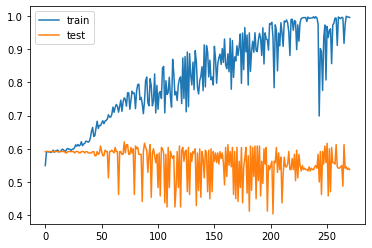

In [ ]:
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [ ]:
# import pickle as pkl
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(252,252,1)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100,activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(2,activation='softmax')
])
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.load_weights('/content/drive/MyDrive/Introduction to Bioinformatics/Models/H3K4me2_3000_26_December_59_5.h5')

In [ ]:
ins = SeqEmbedding()
X_test = ins.fit(sequences=X_test,window_size = 3, stride_size = 1)

In [ ]:
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0],252, 252, 1)
model.evaluate(X_test, y_test)

(1000, 2, 31752)
32/32 [==============================] - 9s 28ms/step - loss: 0.6202 - accuracy: 0.6980


[0.6202206015586853, 0.6980000138282776]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
p = model.predict(X_test)
prediction = []
for x in p:
    if(x[0]>x[1]):
        prediction.append(0)
    else:
        prediction.append(1)
print(f'Accuracy: {accuracy_score(y_test,prediction)}')
print(f'Precision: {precision_score(y_test,prediction)}')
print(f'Recall: {recall_score(y_test,prediction)}')
print(f'F1 Score: {f1_score(y_test,prediction)}')
print(f'MCC Score: {matthews_corrcoef(y_test,prediction)}')

Accuracy: 0.698
Precision: 0.7061340941512125
Recall: 0.8375634517766497
F1 Score: 0.7662538699690402
MCC Score: 0.35856836322113667
